In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')

from dataset import  generate_waseda_student_data2 ,generate_synthetic_data2, calc_true_value2
from policylearners import IPSBasedGradientPolicyLearner, CateBasedGradientPolicyLearner_dr,CateBasedGradientPolicyLearner_ips
from utils import softmax,aggregate_simulation_results,aggregate_simulation_results2

In [2]:
## シミュレーション設定
num_runs = 50 # シミュレーションの繰り返し回数
dim_x = 5 # 特徴量xの次元
num_actions = 10 # 行動数, |A|
beta = -0.01 # データ収集方策のパラメータ
max_iter = 21 # エポック数
test_data_size = 50000 # テストデータのサイズ
random_state = 12345
torch.manual_seed(random_state)
random_ = check_random_state(random_state)
#num_actions_list = [2, 10] # 行動数
num_data = 2000# トレーニングデータのサイズ

In [3]:
theta_1 = random_.normal(size=(dim_x, num_actions))
M_1 = random_.normal(size=(dim_x, num_actions))
b_1 = random_.normal(size=(1, num_actions))
theta_0 = random_.normal(size=(dim_x, num_actions))
M_0 = random_.normal(size=(dim_x, num_actions))
b_0 = random_.normal(size=(1, num_actions))

In [4]:
offline_logged_data = generate_waseda_student_data2(
                num_data=num_data, beta=beta,
                theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
                dim_context=dim_x, num_actions=num_actions, random_state = random_state
            )

In [5]:
offline_logged_data["r_mat"].shape

(2000, 10)

In [6]:
offline_logged_data["a_mat"]

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

##  ログデータ上における評価方策の行動選択確率を計算

In [7]:
def softmax_policy(
    q_func: np.ndarray,
    beta: float = 1.0,
) -> np.ndarray:
    "Generate an evaluation policy via the softmax rule."

    return softmax(beta * q_func)

In [8]:
from scipy.stats import rankdata
def eps_greedy_policy(
    q_func: np.ndarray,
    eps: float = 0.2,
) -> np.ndarray:
    "Generate an evaluation policy via the epsilon-greedy rule."
    is_topk = rankdata(-q_func, method="ordinal", axis=1) == 3
    pi = (1.0 - eps) * is_topk + eps / q_func.shape[1]

    return pi / pi.sum(1)[:, np.newaxis]

In [9]:
print(offline_logged_data["cate_x_a"])
print(offline_logged_data["cate_x_a"].shape)

[[ 9.93343971e-01  9.07042290e-05  7.75922571e-01 ... -9.93659395e-01
  -5.53728203e-03  2.84436367e-01]
 [ 3.64267624e-01 -3.00977109e-03 -2.45341213e-01 ... -2.62245198e-01
  -5.61372623e-02  3.27218675e-01]
 [ 1.06857986e-01  1.13283397e-02  3.33749522e-01 ... -8.02190820e-01
  -9.64902970e-01  5.28979472e-01]
 ...
 [ 1.33737954e-03  9.40820298e-01 -3.28694413e-01 ... -6.17007331e-03
  -1.27279604e-01  5.56778377e-04]
 [ 7.52092647e-01 -9.99926741e-01 -9.98847302e-01 ...  2.87048758e-01
  -5.72160521e-01 -9.98452681e-04]
 [ 9.99798560e-01  9.63203972e-01  1.36686590e-02 ... -3.85624731e-02
  -2.32458670e-06 -1.16996658e-01]]
(2000, 10)


In [10]:
print(offline_logged_data["q_x_a_1"])

[[9.94013203e-01 9.99999998e-01 9.24919313e-01 ... 6.33292091e-03
  9.94461470e-01 3.76011139e-01]
 [4.87981005e-01 9.85690395e-01 6.85862247e-01 ... 5.35106563e-01
  9.40905167e-01 3.28693450e-01]
 [1.06896378e-01 9.99954069e-01 3.87673265e-01 ... 1.92720840e-01
  2.25343861e-02 7.62934771e-01]
 ...
 [1.37798000e-03 9.99701868e-01 6.71305586e-01 ... 4.18690130e-03
  8.60977060e-01 5.56971600e-04]
 [9.99999999e-01 3.23239178e-05 4.79737737e-06 ... 9.91830823e-01
  4.27203527e-01 2.19088505e-10]
 [9.99798560e-01 9.63396080e-01 9.99430117e-01 ... 1.88580484e-12
  2.72235096e-05 3.34659305e-07]]


In [11]:
print

<function print>

In [12]:

## ログデータ上における評価方策の行動選択確率を計算
pi = eps_greedy_policy(offline_logged_data["cate_x_a"])

print(pi)
print(pi.shape)


[[0.82 0.02 0.02 ... 0.02 0.02 0.02]
 [0.82 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.82 ... 0.02 0.02 0.02]
 ...
 [0.02 0.82 0.02 ... 0.02 0.02 0.02]
 [0.82 0.02 0.02 ... 0.02 0.02 0.02]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]
(2000, 10)


## 真の性能の近似値

In [13]:
## 評価方策の真の性能(policy value)を計算
policy_value = calc_true_value2(
        num_data=10000,
        dim_context=dim_x,
        num_actions=num_actions,
        theta_1=theta_1,
        theta_0=theta_0,
        M_1=M_1,
        M_0=M_0,
        b_1=b_1,
        b_0=b_0,
    )

In [14]:
print(policy_value)

5.793081667925557


## AVG推定量

In [15]:
def calc_new_avg(dataset:dict) -> float:
    """
    増加量におけるAVG推定量

    Args:
        dataset (dict): _description_
        pi (np.ndarray): _description_

    Returns:
        float: _description_
    """
    
    
    return dataset["r_mat"].sum(1).mean()


In [16]:
base_score = calc_new_avg(offline_logged_data)

print(base_score)

5.452


## IPS推定量

In [17]:
def calc_new_ips(dataset:dict, pi:np.ndarray) ->float:
    """
    IPS推定量

    Args:
        dataset (dict): _description_
        pi (np.ndarray): _description_

    Returns:
        float: _description_
    """
    
    pi_0 = dataset["pi_0"]
    
    ones = np.ones((dataset["num_data"],dataset["num_actions"]))
    a = dataset["a_mat"]
    not_a = ones-dataset["a_mat"]
    
    
    #r_a_1にかかるウエイトと，r_a_0にかかるウエイトを作成
    w_1 = pi*a / pi_0*a  # n×|A|
    w_0 = ((ones*not_a)-(pi*not_a)) / ((ones*not_a)-(pi_0*not_a)) # n×|A|
    
    w_1 = np.nan_to_num(w_1,nan=0)
    w_0 = np.nan_to_num(w_0, nan=0)
    
    return (dataset["r_mat"]*w_1 + dataset["r_mat"]*w_0).sum(1).mean()
    
    
    

In [18]:
matrix = np.array([[1, 2, 3], [4, 5, 6]])
matrix

array([[1, 2, 3],
       [4, 5, 6]])

In [19]:
matrix.sum(1).sum(0)

21

In [20]:
ips_score = calc_new_ips(offline_logged_data,pi)

print(ips_score)

5.693370722295914


## DR

In [21]:
def calc_new_dr(dataset:dict, pi:np.ndarray, q1_hat:np.ndarray, q0_hat:np.ndarray) ->float:
    """
    IPS推定量

    Args:
        dataset (dict): _description_
        pi (np.ndarray): _description_

    Returns:
        float: _description_
    """
    
    pi_0 = dataset["pi_0"]
    
    ones = np.ones((dataset["num_data"],dataset["num_actions"]))
    a = dataset["a_mat"]
    not_a = ones-dataset["a_mat"]
    
    #r_a_1にかかるウエイトと，r_a_0にかかるウエイトを作成
    
    
    w_ips_1 = (pi*a) / (pi_0*a)  # n×|A|
    w_ips_0 =  ((ones*not_a)-(pi*not_a)) / ((ones*not_a)-(pi_0*not_a)) # n×|A|
    
    w_ips_1 = np.nan_to_num(w_ips_1,nan=0)
    w_ips_0 = np.nan_to_num(w_ips_0, nan=0)
    
    dr =(dataset["r_mat"]-q1_hat*a)*w_ips_1 + (dataset["r_mat"]-q0_hat*not_a)*w_ips_0
    
    dr += (q1_hat*pi + q0_hat*(ones-pi))
    
    return dr.sum(1).mean()
    
    
    

In [22]:
offline_logged_data["q_x_a_0"]

array([[6.69232463e-04, 9.99909294e-01, 1.48996742e-01, ...,
        9.99992315e-01, 9.99998752e-01, 9.15747727e-02],
       [1.23713381e-01, 9.88700166e-01, 9.31203460e-01, ...,
        7.97351761e-01, 9.97042430e-01, 1.47477549e-03],
       [3.83925354e-05, 9.88625729e-01, 5.39237432e-02, ...,
        9.94911660e-01, 9.87437356e-01, 2.33955300e-01],
       ...,
       [4.06004522e-05, 5.88815699e-02, 9.99999999e-01, ...,
        1.03569746e-02, 9.88256664e-01, 1.93223192e-07],
       [2.47907352e-01, 9.99959065e-01, 9.98852099e-01, ...,
        7.04782065e-01, 9.99364047e-01, 9.98452900e-04],
       [5.64801973e-14, 1.92108127e-04, 9.85761458e-01, ...,
        3.85624731e-02, 2.95480963e-05, 1.16996993e-01]])

In [23]:
q0_hat = offline_logged_data["q_x_a_0"] + random_.normal(-0.05, scale=0.025, size=(num_data, num_actions))
q1_hat = offline_logged_data["q_x_a_1"] + random_.normal(-0.05, scale=0.025, size=(num_data, num_actions))

In [24]:
q0_hat = offline_logged_data["q_x_a_0"] + random_.normal(-0.005, scale=0.0025, size=(num_data, num_actions))
q1_hat = offline_logged_data["q_x_a_1"] + random_.normal(-0.005, scale=0.0025, size=(num_data, num_actions))

In [25]:
dr_score = calc_new_dr(offline_logged_data,pi, q1_hat, q0_hat)

print(dr_score)

5.748411043552157


## MSE

In [26]:
## シミュレーション設定
num_runs = 5000 # シミュレーションの繰り返し回数
dim_x = 10 # 特徴量xの次元
num_actions = 21 # 行動数, |A|
beta = -0.01 # データ収集方策のパラメータ
max_iter = 21 # エポック数
test_data_size = 50000 # テストデータのサイズ
random_state = 12345
torch.manual_seed(random_state)
random_ = check_random_state(random_state)
#num_actions_list = [2, 10] # 行動数
num_data_list = [200,1000,5000,10000,40000]# トレーニングデータのサイズ

In [27]:
theta_1 = random_.normal(size=(dim_x, num_actions))
M_1 = random_.normal(size=(dim_x, num_actions))
b_1 = random_.normal(size=(1, num_actions))
theta_0 = random_.normal(size=(dim_x, num_actions))
M_0 = random_.normal(size=(dim_x, num_actions))
b_0 = random_.normal(size=(1, num_actions))

## データ数が変化する時

In [28]:
result_df_list = []
## 期待報酬関数を定義するためのパラメータを抽出
theta_1 = random_.normal(size=(dim_x, num_actions))
M_1 = random_.normal(size=(dim_x, num_actions))
b_1 = random_.normal(size=(1, num_actions))
theta_0 = random_.normal(size=(dim_x, num_actions))
M_0 = random_.normal(size=(dim_x, num_actions))
b_0 = random_.normal(size=(1, num_actions))

for num_data in num_data_list:
    
    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value2(
        num_data=10000,
        dim_context=dim_x,
        num_actions=num_actions,
        theta_1=theta_1,
        theta_0=theta_0,
        M_1=M_1,
        M_0=M_0,
        b_1=b_1,
        b_0=b_0,  
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_waseda_student_data2(
            num_data=num_data, beta=beta,
            theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
            dim_context=dim_x, num_actions=num_actions,
            random_state = _,
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["cate_x_a"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["avg"] = calc_new_avg(offline_logged_data)
        estimated_policy_values["ips"] = calc_new_ips(offline_logged_data, pi)
        
        estimated_policy_values["dr"] = calc_new_dr(
            offline_logged_data, pi,
            q0_hat = offline_logged_data["q_x_a_0"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
            q1_hat = offline_logged_data["q_x_a_1"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions))
        )
        
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results2(
            estimated_policy_value_list, policy_value, "num_data", num_data,
        )
    )
result_df_data = pd.concat(result_df_list).reset_index(level=0)

num_data=200...:  10%|█         | 508/5000 [00:04<00:36, 123.46it/s]


KeyboardInterrupt: 

In [ ]:
result_df_data

,index,est,value,num_data,se,bias,variance,true_value
0,0,avg,9.785000,200,3.975658e-01,0.492449,5.072146e-03,10.415528
1,0,ips,10.735000,200,1.020622e-01,0.000083,1.079517e-01,10.415528
2,0,dr,10.446034,200,9.305977e-04,0.000153,1.837532e-03,10.415528
3,1,avg,9.930000,200,2.357376e-01,0.492449,4.675066e-02,10.415528
4,1,ips,11.297400,200,7.776979e-01,0.000083,7.938098e-01,10.415528
...,...,...,...,...,...,...,...,...
74995,4998,ips,10.419222,40000,1.364412e-05,0.000183,2.972136e-04,10.415528
74996,4998,dr,10.414744,40000,6.151921e-07,0.000200,1.785341e-04,10.415528
74997,4999,avg,9.713125,40000,4.933703e-01,0.493978,1.869006e-07,10.415528
74998,4999,ips,10.369148,40000,2.151123e-03,0.000183,1.078079e-03,10.415528


In [ ]:
plt.style.use('ggplot')
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

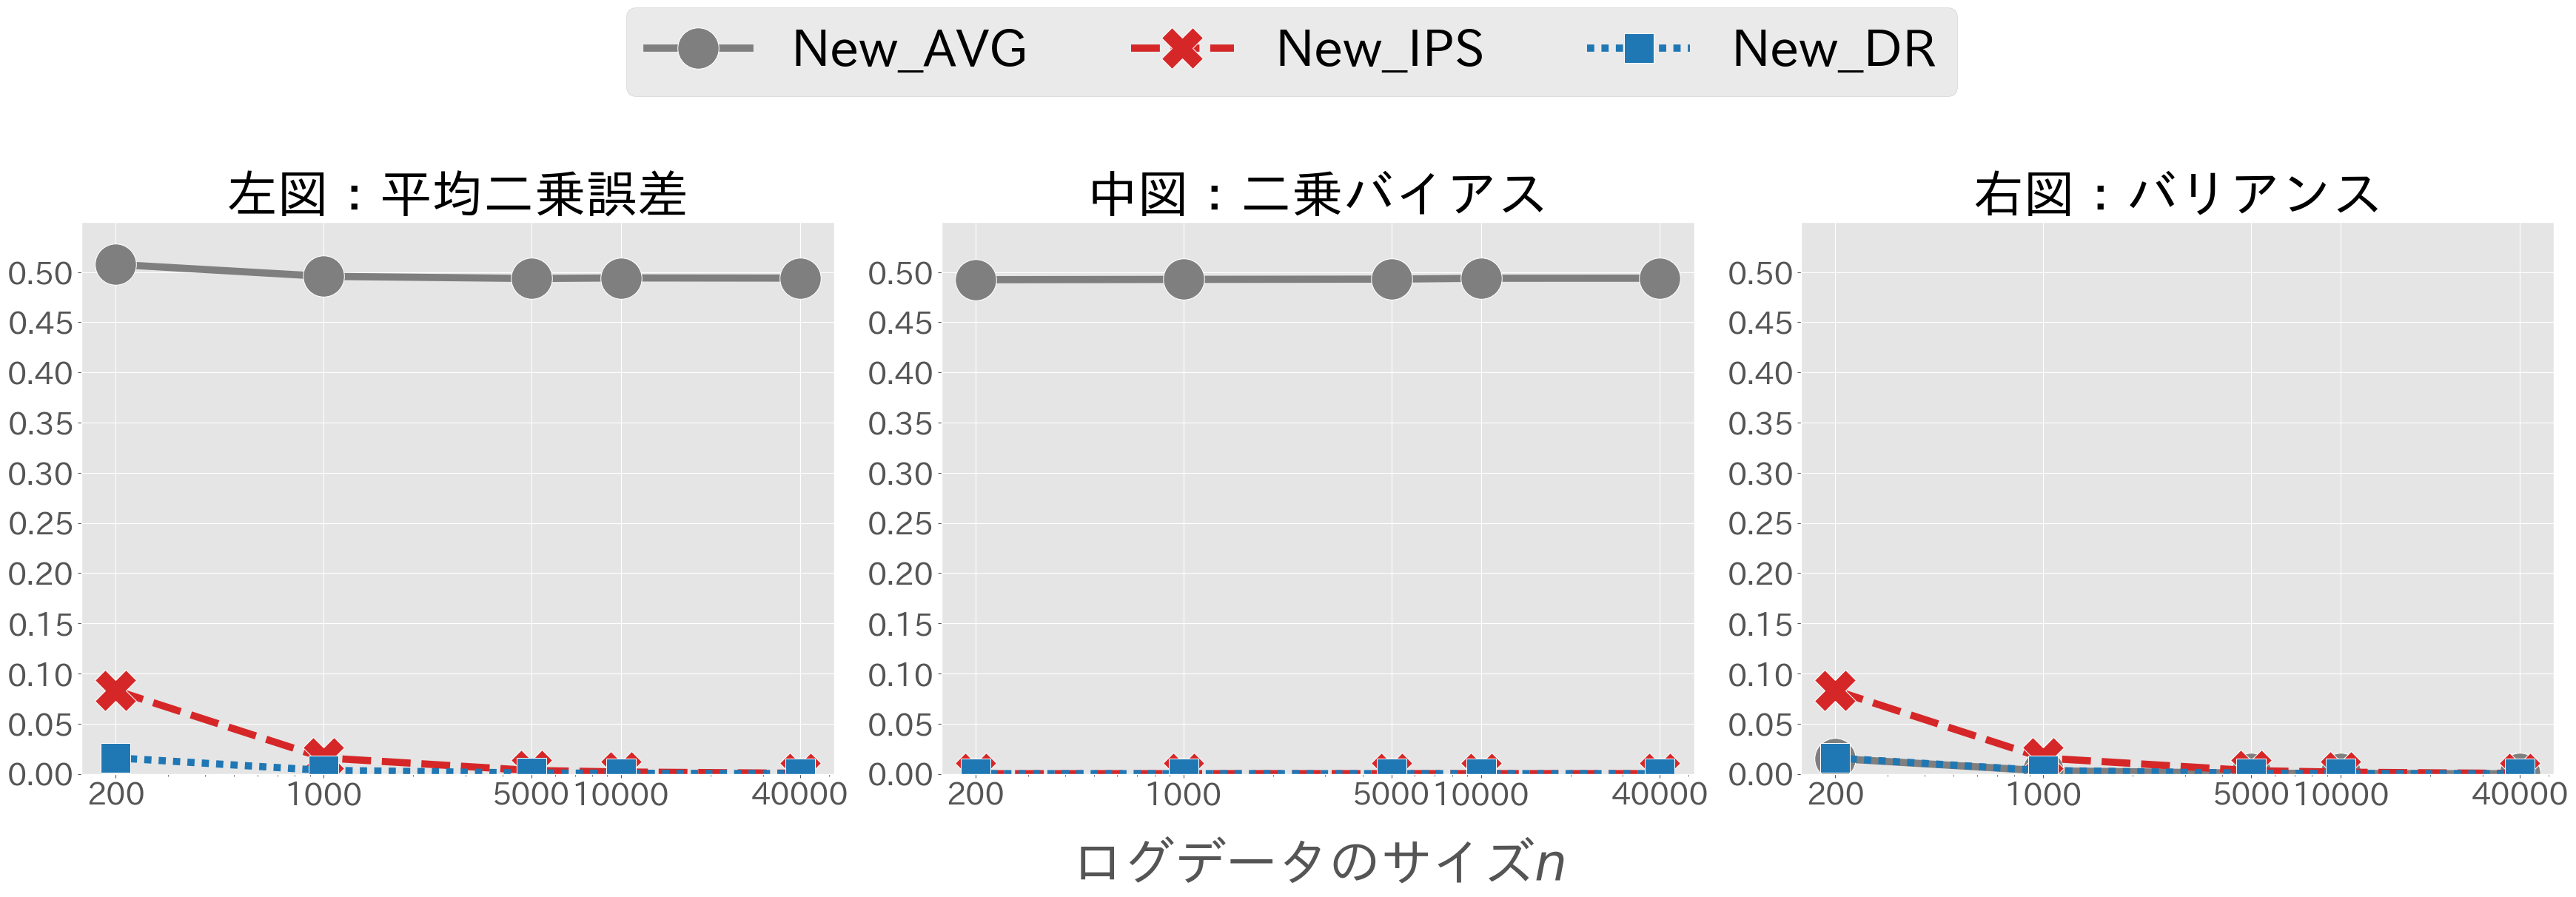

In [ ]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        #palette=["tab:grey", "tab:red"],
        palette=["tab:grey", "tab:red", "tab:blue"],
        data=result_df_data,
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.55)
    ax.set_yticks(np.arange(0.0,0.55,0.05))
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["New_AVG", "New_IPS", "New_DR"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")


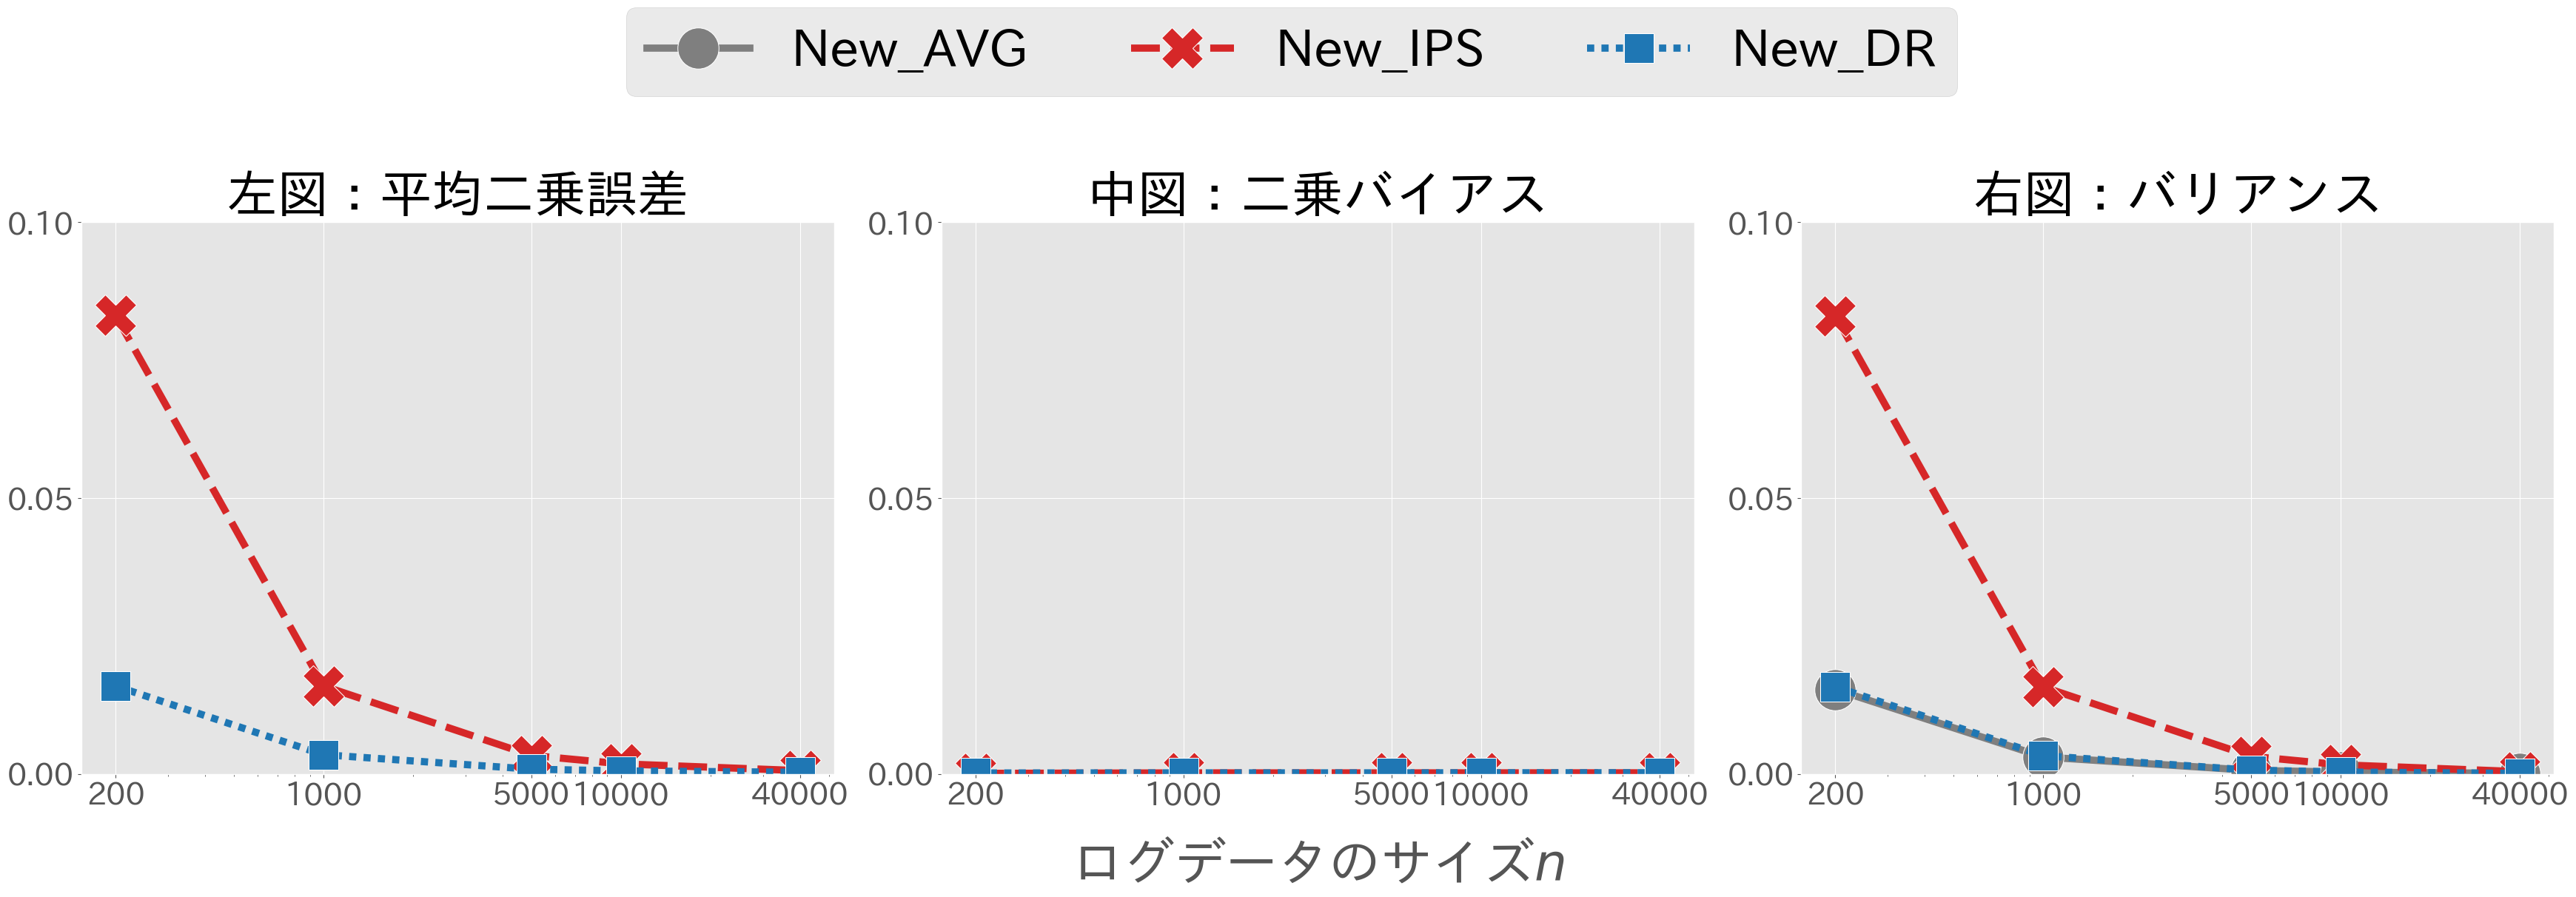

In [ ]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        #palette=["tab:grey", "tab:red"],
        palette=["tab:grey", "tab:red", "tab:blue"],
        data=result_df_data,
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.10)
    ax.set_yticks(np.arange(0.0,0.15,0.05))
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["New_AVG", "New_IPS", "New_DR"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")


In [ ]:
print(i for i in range(1,10))

<generator object <genexpr> at 0x000002171A63FEB0>


In [ ]:
np.arange(1,10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

# アクションの数を変更

In [29]:
## シミュレーション設定
num_runs = 50# シミュレーションの繰り返し回数
dim_x = 10 # 特徴量xの次元
#num_actions = 21 # 行動数, |A|
beta = -0.01 # データ収集方策のパラメータ
max_iter = 21 # エポック数
test_data_size = 50000 # テストデータのサイズ
random_state = 12345
torch.manual_seed(random_state)
random_ = check_random_state(random_state)
num_actions_list = [200,500,1000,2000,4000] # 行動数
#num_data_list = [200,1000,5000,10000,40000]# トレーニングデータのサイズ
num_data = 1000

In [30]:
result_df_list = []
## 期待報酬関数を定義するためのパラメータを抽出


for num_actions in num_actions_list:
    theta_1 = random_.normal(size=(dim_x, num_actions))
    M_1 = random_.normal(size=(dim_x, num_actions))
    b_1 = random_.normal(size=(1, num_actions))
    theta_0 = random_.normal(size=(dim_x, num_actions))
    M_0 = random_.normal(size=(dim_x, num_actions))
    b_0 = random_.normal(size=(1, num_actions))
    
    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value2(
        num_data=10000,
        dim_context=dim_x,
        num_actions=num_actions,
        theta_1=theta_1,
        theta_0=theta_0,
        M_1=M_1,
        M_0=M_0,
        b_1=b_1,
        b_0=b_0,  
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_actions={num_actions}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_waseda_student_data2(
            num_data=num_data, beta=beta,
            theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
            dim_context=dim_x, num_actions=num_actions,
            random_state = _,
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["cate_x_a"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["avg"] = calc_new_avg(offline_logged_data)
        estimated_policy_values["new_ips"] = calc_new_ips(offline_logged_data, pi)
        
        estimated_policy_values["new_dr"] = calc_new_dr(
            offline_logged_data, pi,
            q0_hat = offline_logged_data["q_x_a_0"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
            q1_hat = offline_logged_data["q_x_a_1"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions))
        )
        
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results2(
            estimated_policy_value_list, policy_value, "num_actions", num_actions,
        )
    )
result_df_actions = pd.concat(result_df_list).reset_index(level=0)

num_actions=4000...: 100%|██████████| 50/50 [02:33<00:00,  3.08s/it]


In [31]:
result_df_actions

,index,est,value,num_actions,se,bias,variance,true_value
0,0,avg,98.302000,200,0.692997,6.373215e-01,0.001166,99.134464
1,0,new_ips,99.748474,200,0.377008,1.689608e-02,0.234280,99.134464
2,0,new_dr,99.084671,200,0.002479,1.652648e-07,0.002520,99.134464
3,1,avg,98.185000,200,0.901482,6.373215e-01,0.022843,99.134464
4,1,new_ips,98.337352,200,0.635389,1.689608e-02,0.859510,99.134464
...,...,...,...,...,...,...,...,...
745,48,new_ips,2005.557710,4000,0.071885,2.208081e-03,0.048895,2005.825823
746,48,new_dr,2006.334874,4000,0.259133,4.795761e-02,0.084134,2005.825823
747,49,avg,2005.356000,4000,0.220734,3.218332e-01,0.009502,2005.825823
748,49,new_ips,2005.375838,4000,0.202487,2.208081e-03,0.162405,2005.825823


In [32]:
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

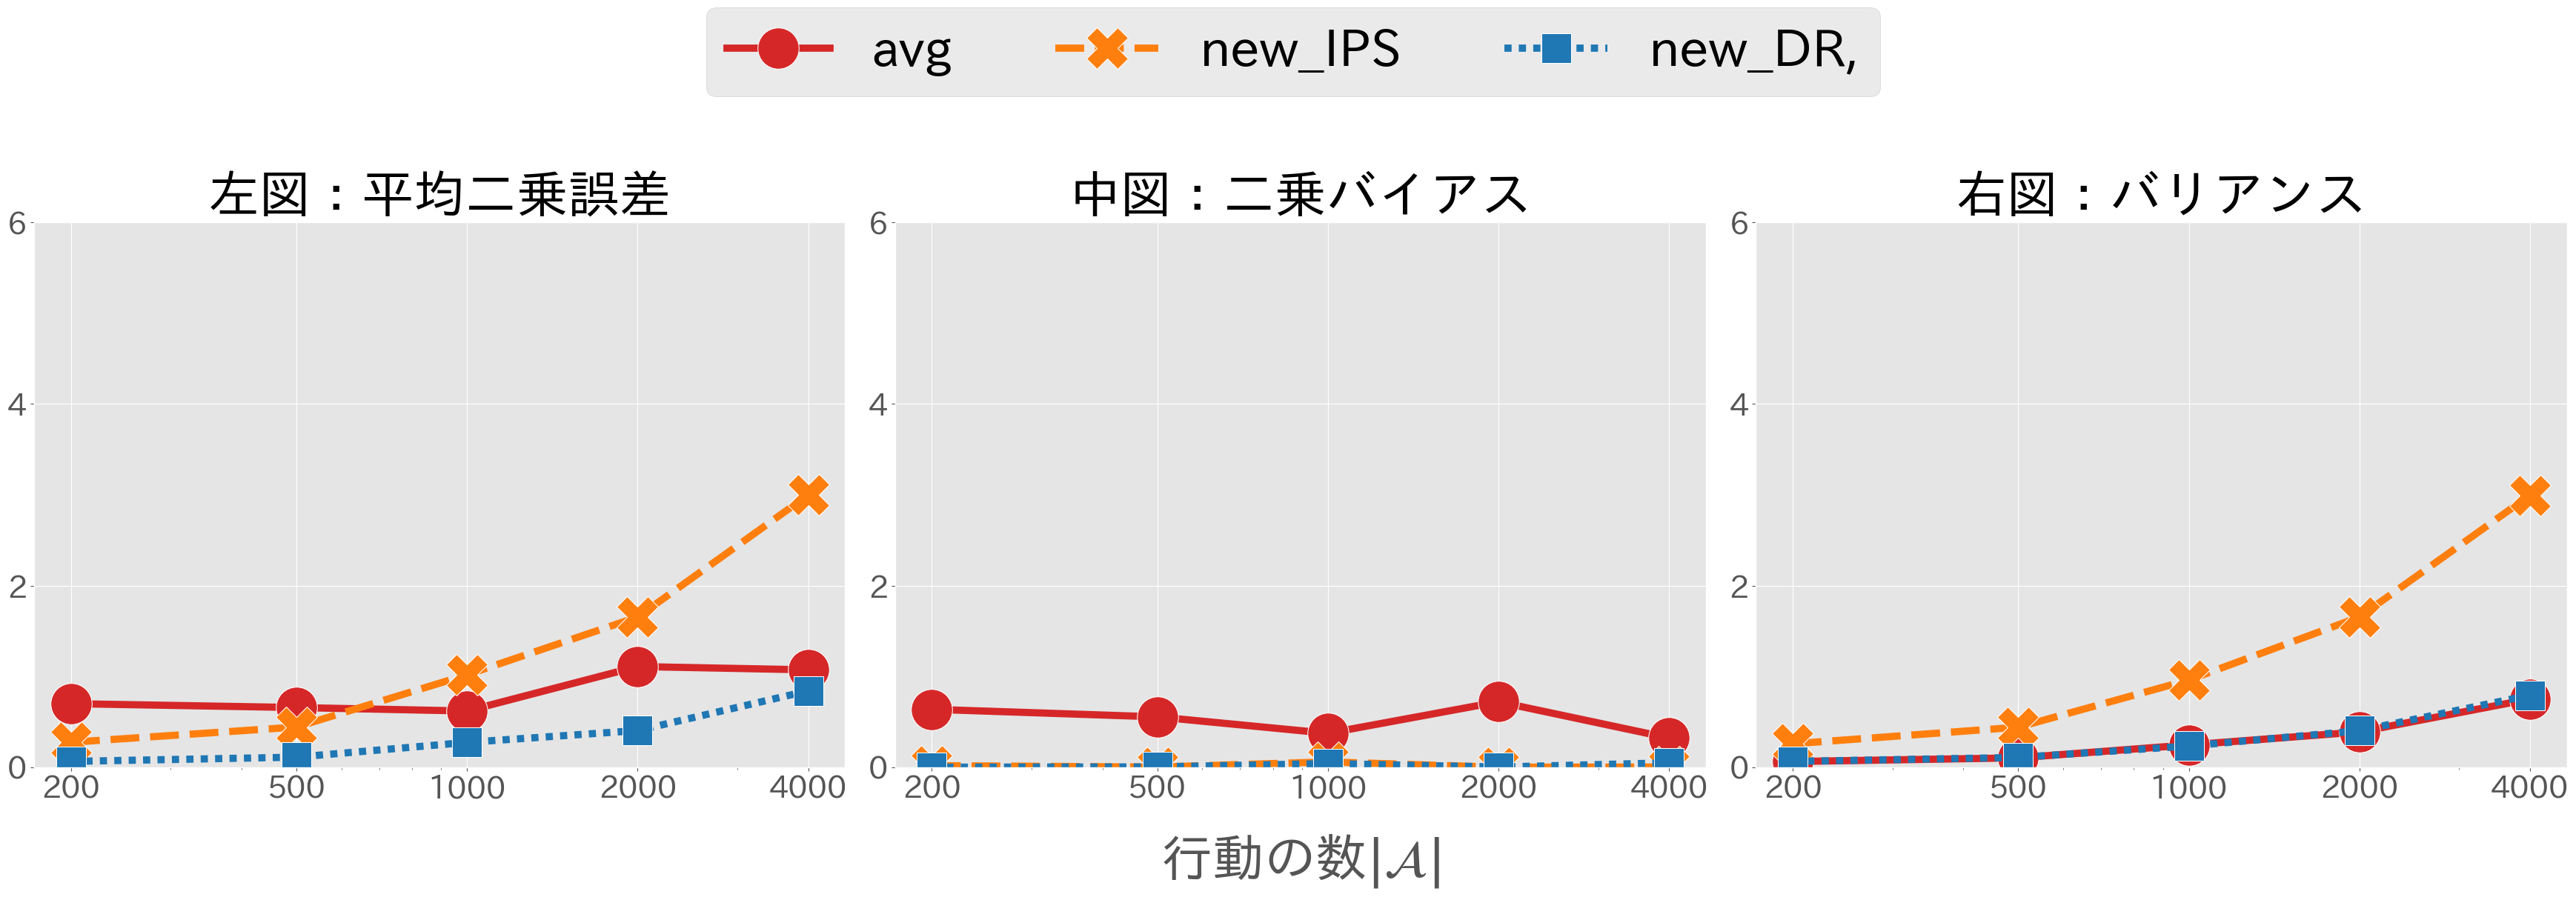

In [33]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_actions",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange","tab:blue"],
        data=result_df_actions.query("est=='avg' or est == 'new_ips' or est == 'new_dr' ")
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 6.0)
    ax.set_yticks([0, 2, 4, 6,  ])
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"行動の数$|\mathcal{A}|$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_actions_list)
    ax.set_xticklabels(num_actions_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["avg", "new_IPS", "new_DR,"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")